# **Happy Customers**
---

# Setup

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from a CSV file
dataset = pd.read_csv('ACME-HappinessSurvey2020.csv')

# Extract the input features (x) and output (y) from the dataset
x = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

# Initial Data Exploration

In [ ]:
# Create a DataFrame with the feature columns
df_features = pd.DataFrame(x, columns=['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])

# Plot the distribution of scores for each feature
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(df_features.columns):
    sns.histplot(df_features[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Modelling

c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_

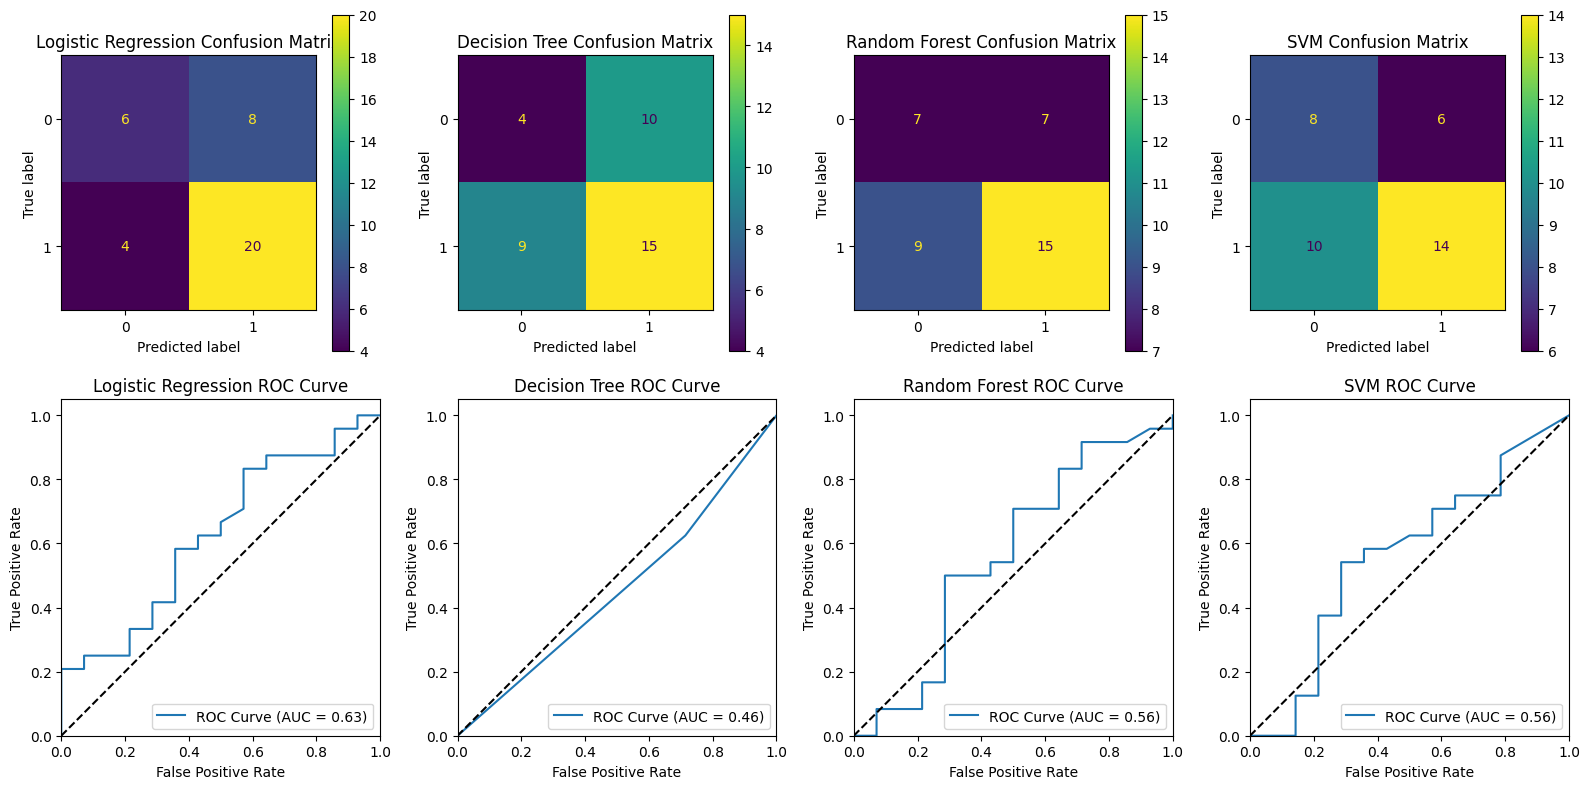

In [18]:
# Initialize the models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True)
]

# Define the model names for labeling
model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM'
]

# Create subplots for confusion matrices and ROC curves
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Iterate over models
for i, model in enumerate(models):
    # Train the model
    model.fit(x_train, y_train)
    
    # Make predictions
    y_pred = model.predict(x_test)
    y_pred_prob = model.predict_proba(x_test)[:, 1]
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    #sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=axes[0, i])
    #axes[0, i].set_title(f'{model_names[i]} Confusion Matrix')
    #axes[0, i].set_xlabel('Predicted Labels')
    #axes[0, i].set_ylabel('True Labels')
    
    plot_confusion_matrix(model, x_test, y_test, ax=axes[0, i])
    axes[0, i].set_title(f'{model_names[i]} Confusion Matrix')
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    axes[1, i].plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
    axes[1, i].plot([0, 1], [0, 1], 'k--')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('False Positive Rate')
    axes[1, i].set_ylabel('True Positive Rate')
    axes[1, i].set_title(f'{model_names[i]} ROC Curve')
    axes[1, i].legend(loc='lower right')

# Adjust spacing and layout
plt.tight_layout()
plt.show()